# HOMEWORK 14 FOR LECTURE 15

In this homework we will be working with the Fashion MNIST dataset. You will be given a classifier which suffers from considerable overfitting. Your objective will be to employ regularization techniques to mitigate the overfitting problem.

Let's start with the usual imports.

In [1]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten, Input, MaxPooling2D, BatchNormalization
from tensorflow.keras import Model
from time import time
from tensorflow.keras.utils import plot_model
from IPython.display import Image

from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]

# Set the seeds for reproducibility
from numpy.random import seed
from tensorflow.random import set_seed
seed_value = 1234578790
seed(seed_value)
set_seed(seed_value)

2024-07-26 16:51:53.332594: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-26 16:51:53.739821: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-26 16:51:53.863647: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-26 16:51:54.338005: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-26 16:51:58.738403: W tensorflow/compiler/tf2

### Dataset

The MNIST fashgion dataset [link](https://github.com/zalandoresearch/fashion-mnist) was build by Zalando Reasearch tem consists of monochrome images of different type of clothing, namely:
* 0	T-shirt/top
* 1	Trouser
* 2	Pullover
* 3	Dress
* 4	Coat
* 5	Sandal
* 6	Shirt
* 7	Sneaker
* 8	Bag
* 9	Ankle boot

It is also one of the Keras built-in datasets. Let's load the images and quickly inspect it.

In [2]:
labels_str = """0 T-shirt/top
1 Trouser
2 Pullover
3 Dress
4 Coat
5 Sandal
6 Shirt
7 Sneaker
8 Bag
9 Ankle boot"""
labels = [lb[2:] for lb in labels_str.split('\n')]
print(labels)

['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


In [3]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

# Dataset params
num_classes = 10
size1, size2 = x_train.shape[1], x_train.shape[2]

print('Train set:   ', len(y_train), 'samples')
print('Test set:    ', len(y_test), 'samples')
print('Sample dims: ', x_train.shape)

Train set:    60000 samples
Test set:     10000 samples
Sample dims:  (60000, 28, 28)


Let's visualise some random samples.

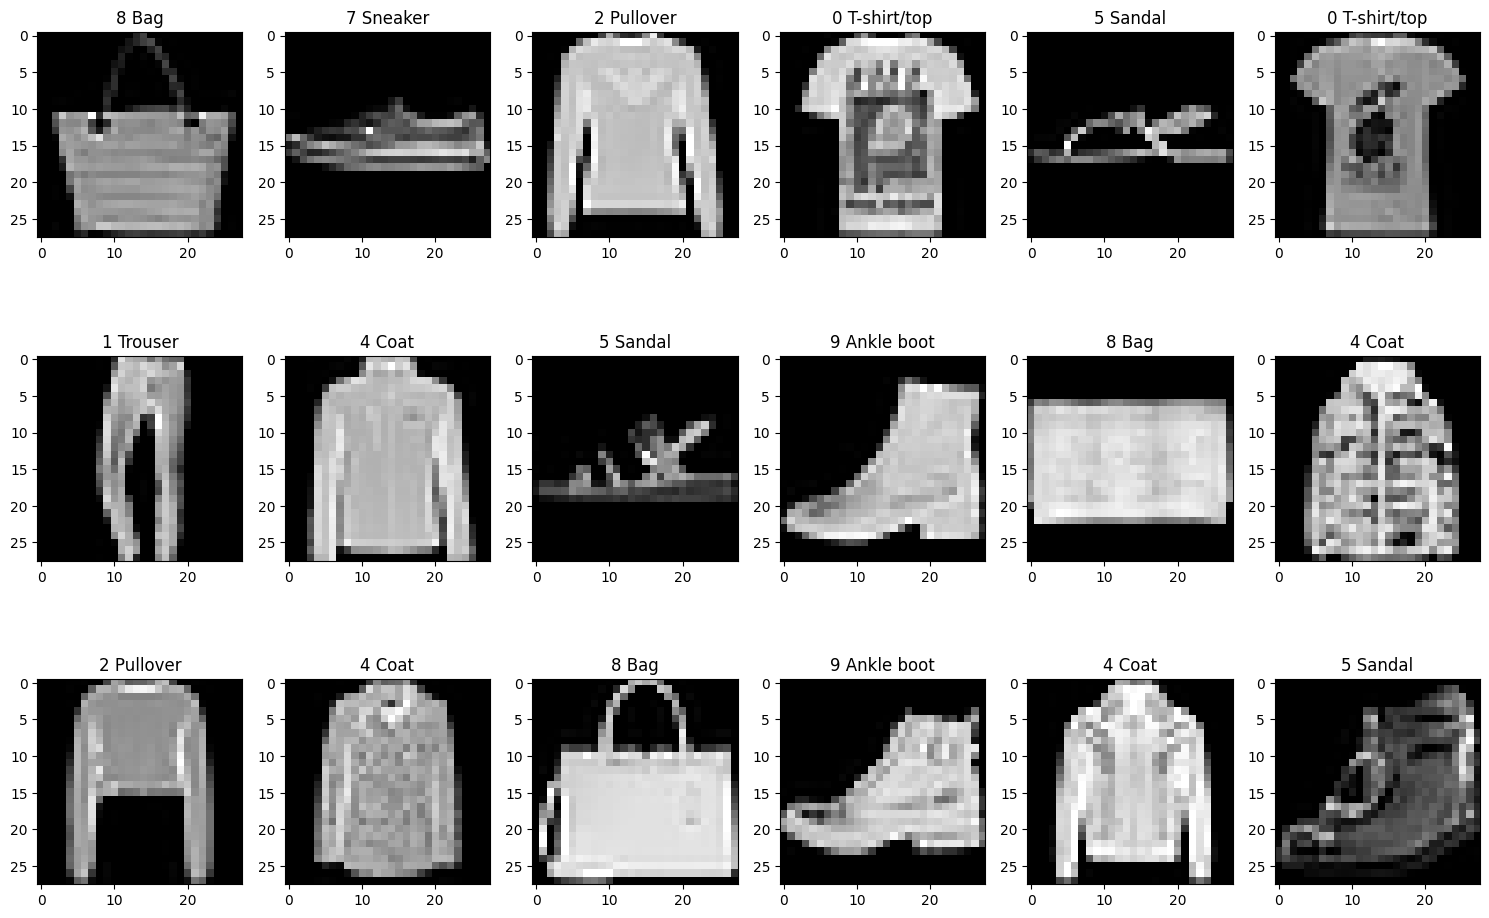

In [4]:
def plot_image_table(x_train, y_train, rows=3, cols=6):
    cnt = 1
    for row in range(rows):
        for col in range(cols):
            idx = np.random.randint(len(x_train))
            plt.subplot(rows, cols, cnt)
            plt.imshow(x_train[idx, ...], cmap='gray')
            plt.title(f"{y_train[idx]} {labels[y_train[idx]]}")
            cnt += 1
    plt.tight_layout()
    plt.show()

plot_image_table(x_train, y_train)

### Building the Classifier

We are now going to build the baseline classifier that you will use throughout this homework.

In [5]:
# Data normalization
x_train = x_train/255
x_test = x_test/255

In [6]:
def create_model(*layers):
    inputs = net = layers[0]    
    for l in layers[1:]:
        net = l(net)
    model = Model(inputs,net)
    return model

def show_model(model):
    model.summary()
    plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
    return Image('model_plot.png',width=600)
    

model = create_model(
    Input(shape=(28, 28, 1)),
    Conv2D(32, kernel_size=(3, 3), activation="relu", padding='same'),
    Flatten(),
    Dense(128),
    Dense(10, activation="softmax")
)

I0000 00:00:1722001943.361599  237944 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:02:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1722001944.675120  237944 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:02:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1722001944.675218  237944 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:02:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1722001944.679267  237944 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:02:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1722001944.679450  237944 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:02:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,213,002 (12.26 MB)

 Trainable params: 3,213,002 (12.26 MB)

 Non-trainable params: 0 (0.00 B)

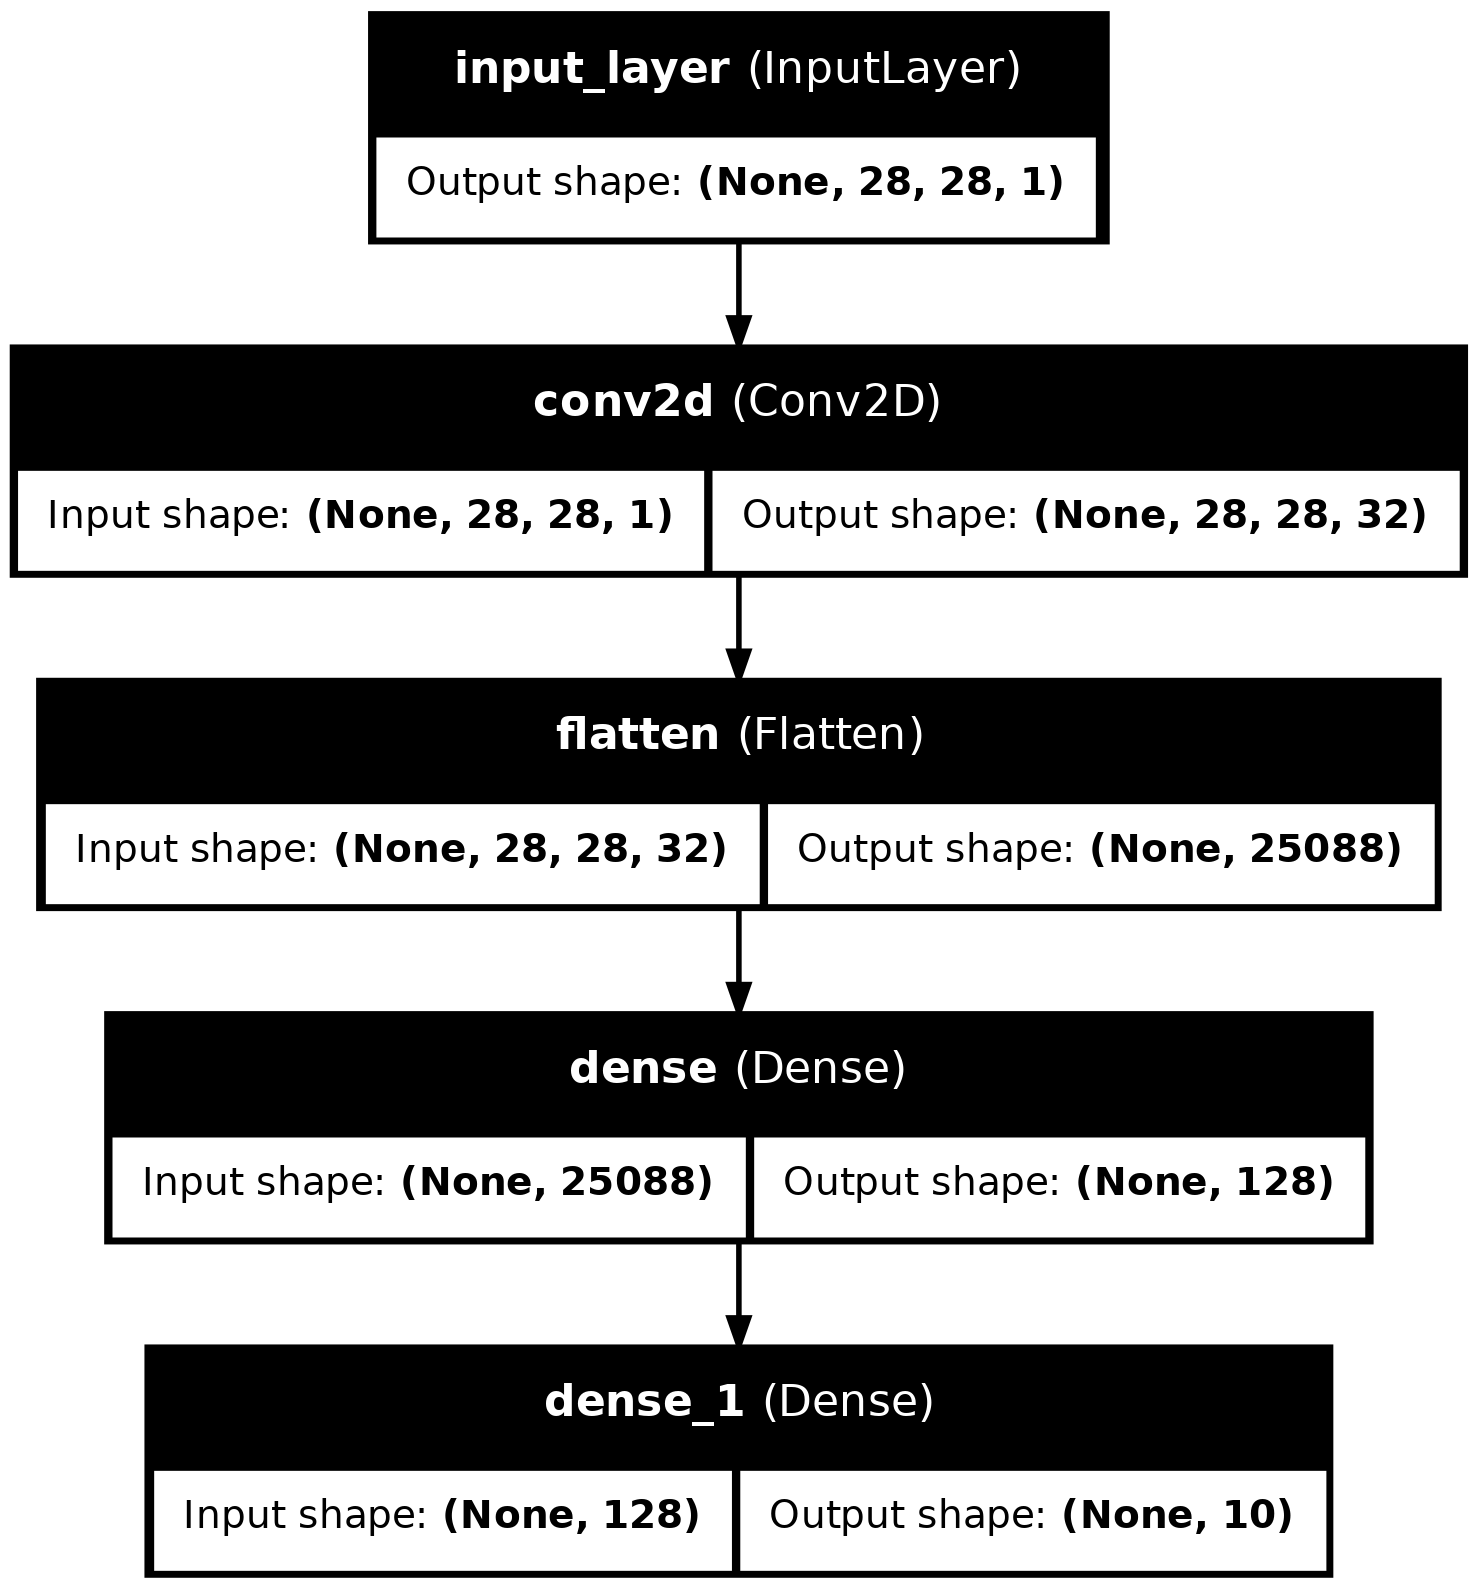

In [7]:
show_model(model)

In [21]:
epochs = 50
batch_size = 64

def fit_model(model, validation_split=0.1):    
    model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
    start = time()
    h = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_test, y_test), validation_split=validation_split)
    print('Elapsed time', time() - start)
    return h

def fit_model_generator(model, generator, validation_split=0.1):    
    steps_per_epoch = len(y_train) // batch_size
    model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
    start = time()
    h = model.fit(generator, steps_per_epoch=steps_per_epoch, epochs=epochs, validation_data=(x_test, y_test), validation_split=validation_split)
    print('Elapsed time', time() - start)
    return h

In [ ]:
history = fit_model(model)

Train Acc      0.9971666932106018
Validation Acc 0.8801000118255615


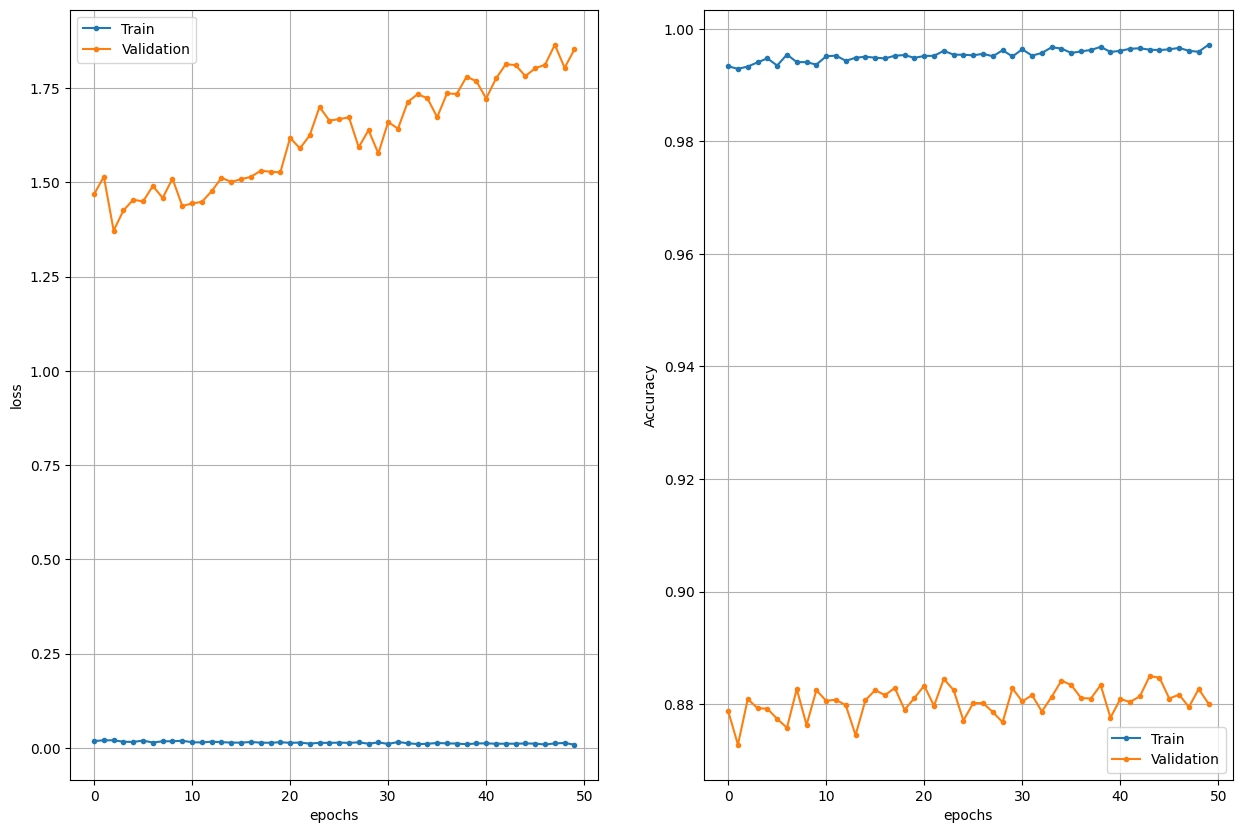

In [11]:
def plot_history(history):
    h = history.history
    epochs = range(len(h['loss']))

    plt.subplot(121), plt.plot(epochs, h['loss'], '.-', epochs, h['val_loss'], '.-')
    plt.grid(True), plt.xlabel('epochs'), plt.ylabel('loss')
    plt.legend(['Train', 'Validation'])
    plt.subplot(122), plt.plot(epochs, h['accuracy'], '.-',
                               epochs, h['val_accuracy'], '.-')
    plt.grid(True), plt.xlabel('epochs'), plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'])
        
    print('Train Acc     ', h['accuracy'][-1])
    print('Validation Acc', h['val_accuracy'][-1])

def plot_histories(histories, labels):
    plt.figure(figsize=(12, 5))
    
    for i, (history, label) in enumerate(zip(histories, labels)):
        h = history.history
        epochs = range(len(h['loss']))
        
        plt.subplot(121)
        plt.plot(epochs, h['loss'], '.-', label=f'Train Loss-{label}')
        plt.plot(epochs, h['val_loss'], '.--', label=f'Val Loss-{label}')
        
        plt.subplot(122)
        plt.plot(epochs, h['accuracy'], '.-', label=f'Train Accuracy-{label}')
        plt.plot(epochs, h['val_accuracy'], '.--', label=f'Val Accuracy-{label}')

    plt.subplot(121)
    plt.grid(True)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(122)
    plt.grid(True)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()
    
    for history, label in zip(histories, labels):
        h = history.history
        print(f'Train Accuracy {label}:', h['accuracy'][-1])
        print(f'Validation Accuracy {label}:', h['val_accuracy'][-1])

plot_history(history)

As you can see, the classifier suffers from massive overfitting. The validation accuracy is around 88% while the training accuracy is close to 1.

### Combat the Overfitting!

Now it is your turn. Use the classifier as a baseline, include some regularization techniques and try to improve the classification performance. You can try any techniques you might see fit, e.g.,
* Dropout
* Batch normalization
* Weight regularization
* Data augmentation 
* Early stopping 
* Pooling
* Reducing the number of parameters (the size of the network)
* ...

There are to objective you shall fulfill in order to successfully complete this homework:
* The validation accuracy shall be above 91%
* Your network (with all the regularizations applied) shall **not** be larger than the baseline

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,213,002 (12.26 MB)

 Trainable params: 3,213,002 (12.26 MB)

 Non-trainable params: 0 (0.00 B)

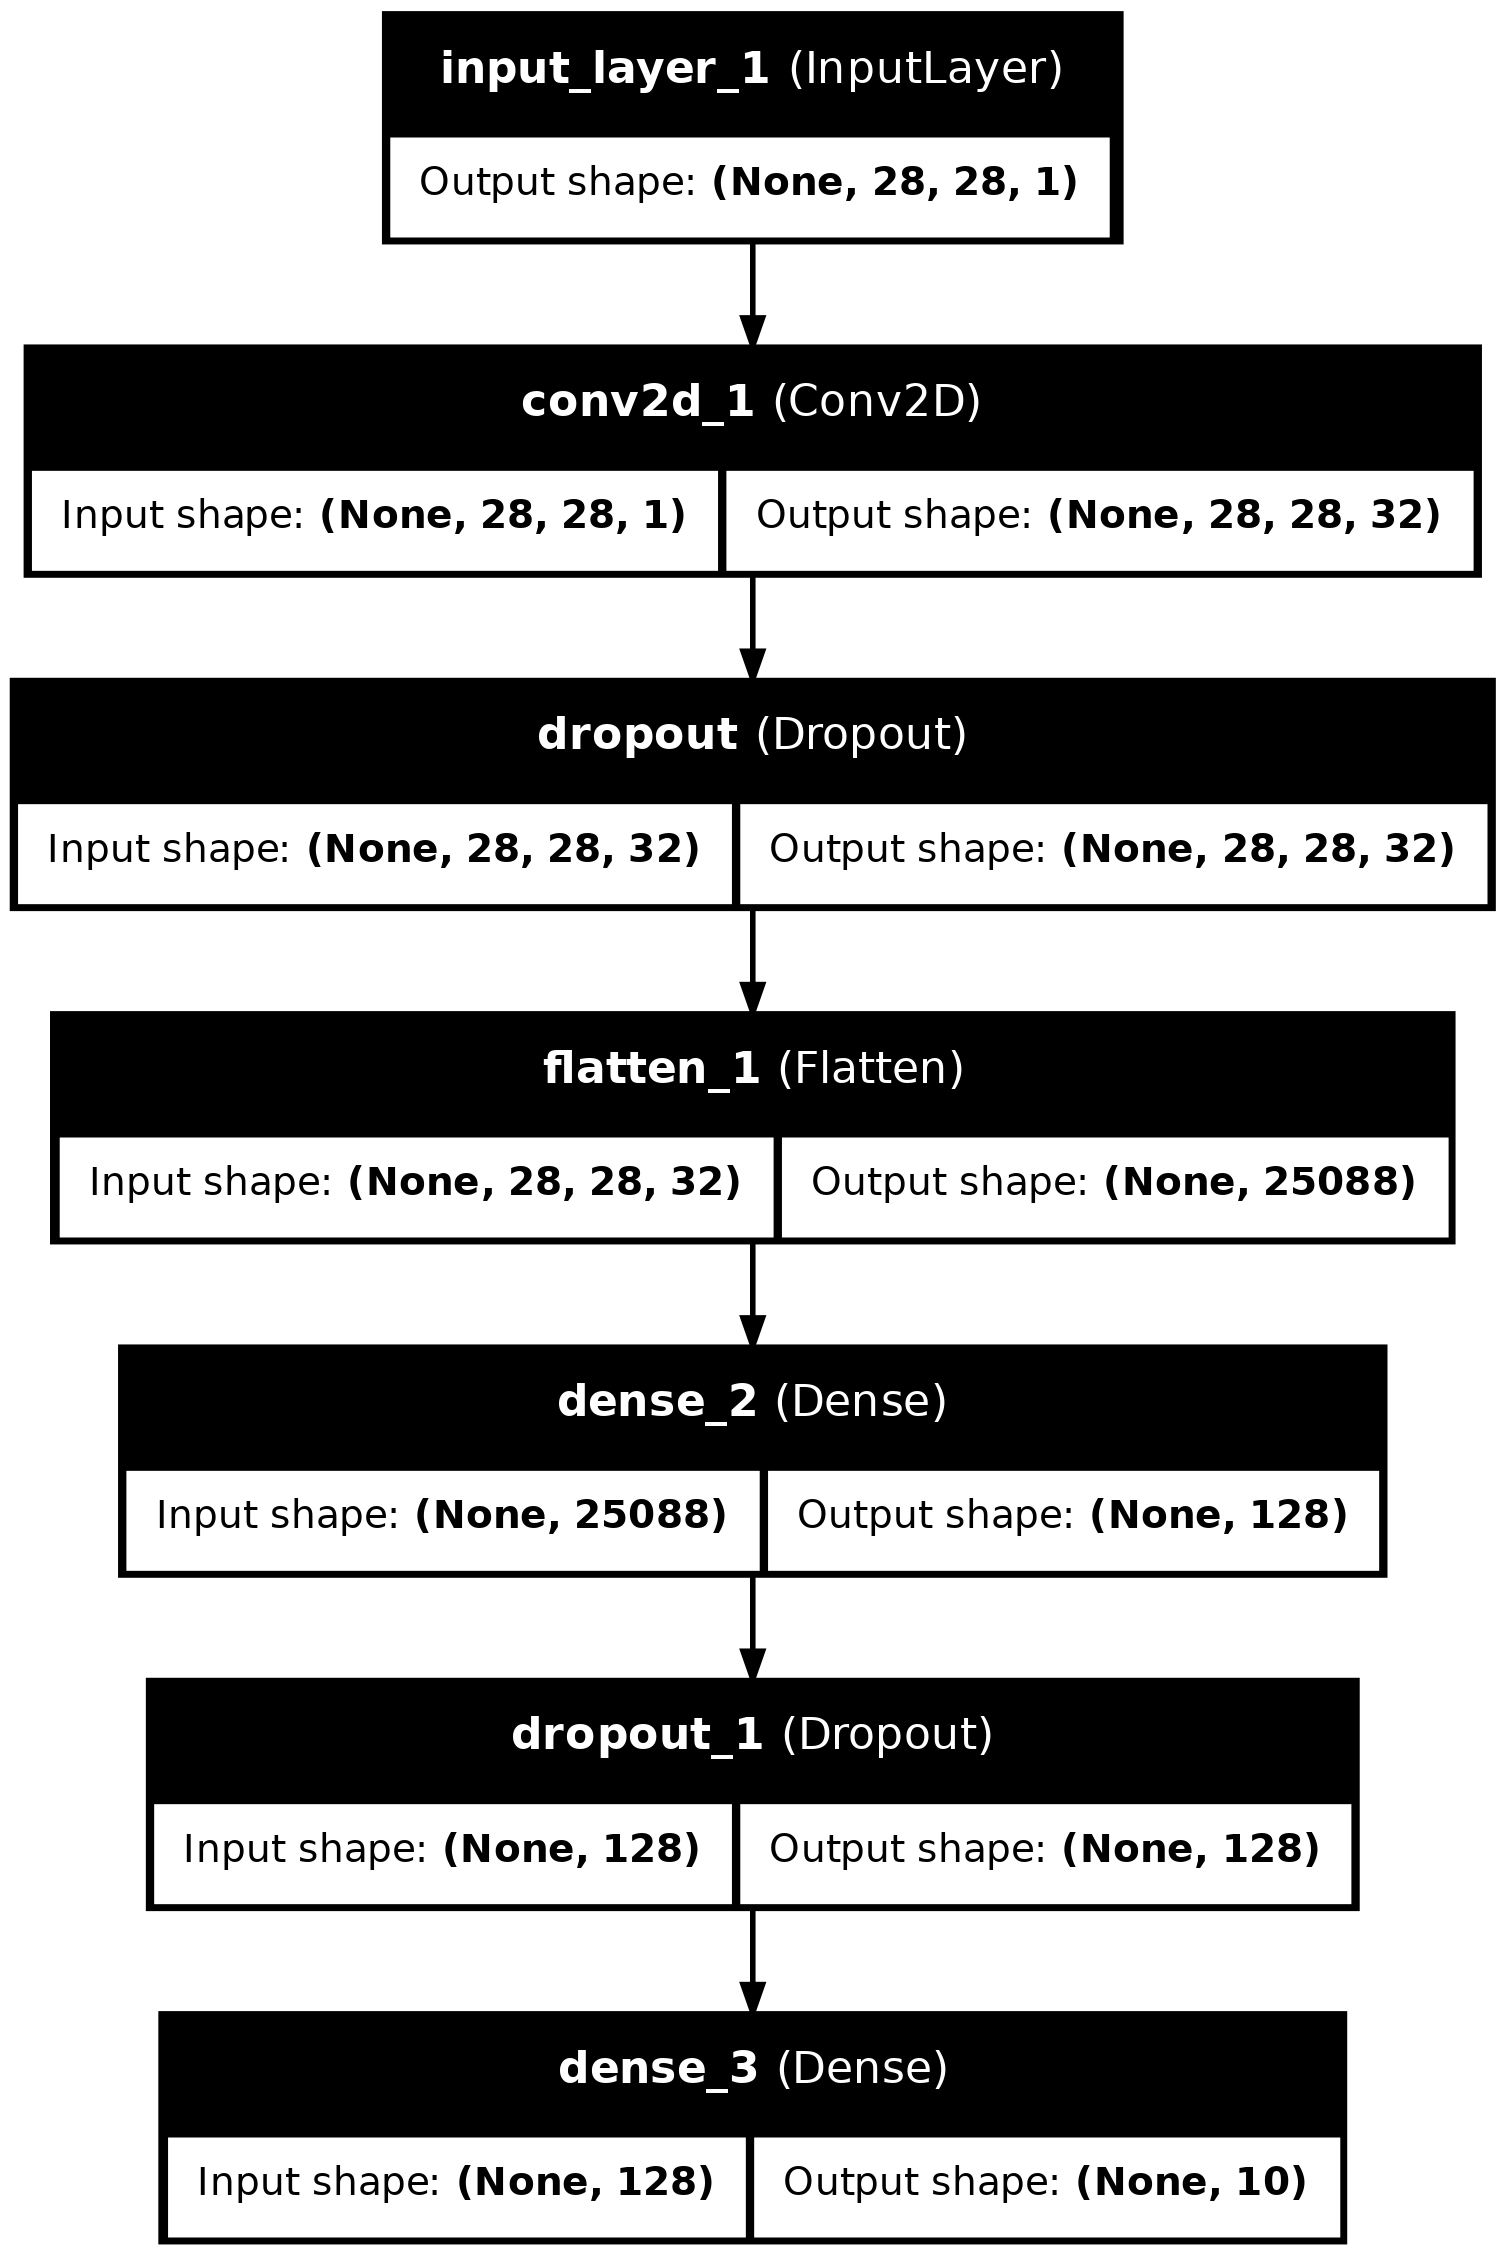

In [12]:
# Modify the baseline classifier in order to reduce the overfitting and make the performance more robust
model = create_model(
    Input(shape=(28, 28, 1)), 
    Conv2D(32, kernel_size=(3, 3), activation="relu", padding='same'), 
    Dropout(0.2), 
    Flatten(), 
    Dense(128), 
    Dropout(0.2),
    Dense(10, activation="softmax")
)
show_model(model)

In [13]:
history1 = fit_model(model)

Epoch 1/50


2024-07-26 16:58:47.469672: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1043', 164 bytes spill stores, 164 bytes spill loads

2024-07-26 16:58:48.005734: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1043', 432 bytes spill stores, 432 bytes spill loads



933/938 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8118 - loss: 0.5686

2024-07-26 16:58:55.381152: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1043', 24 bytes spill stores, 24 bytes spill loads

2024-07-26 16:58:55.886370: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1043', 24 bytes spill stores, 24 bytes spill loads

2024-07-26 16:58:55.889732: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1043', 36 bytes spill stores, 40 bytes spill loads



938/938 ━━━━━━━━━━━━━━━━━━━━ 16s 10ms/step - accuracy: 0.8121 - loss: 0.5676 - val_accuracy: 0.8812 - val_loss: 0.3273
Epoch 2/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8960 - loss: 0.2929 - val_accuracy: 0.8899 - val_loss: 0.3080
Epoch 3/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9075 - loss: 0.2524 - val_accuracy: 0.8939 - val_loss: 0.3030
Epoch 4/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9178 - loss: 0.2243 - val_accuracy: 0.8966 - val_loss: 0.2963
Epoch 5/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9262 - loss: 0.2037 - val_accuracy: 0.8952 - val_loss: 0.3071
Epoch 6/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9310 - loss: 0.1877 - val_accuracy: 0.9003 - val_loss: 0.3081
Epoch 7/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9352 - loss: 0.1736 - val_accuracy: 0.8899 - val_loss: 0.3445
Epoch 8/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9375 - loss: 0.1657 - val_accuracy: 0.8986 - va

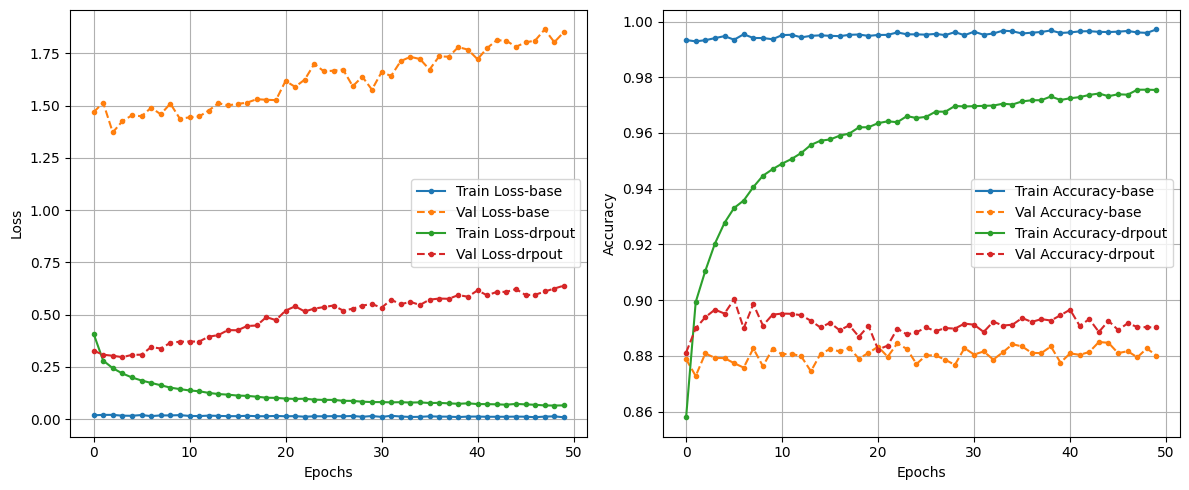

Train Accuracy base: 0.9971666932106018
Validation Accuracy base: 0.8801000118255615
Train Accuracy drpout: 0.975433349609375
Validation Accuracy drpout: 0.8902000188827515


In [14]:

plot_histories([history,history1],["base","drpout"])


### Data Augmentation

In [15]:
from sklearn.utils import shuffle

def datagen(x, y, batch_size):
    num_samples = len(y)
    while True:
        for idx in range(0, num_samples, batch_size):
            x_ = x[idx:idx + batch_size, ...]
            y_ = y[idx:idx + batch_size]
            
            if len(y_) < batch_size:
                x, y = shuffle(x, y)
                break
            
            # Augmentation
            for idx_aug in range(batch_size):
                if np.random.rand() > 0.5:
                    x_[idx_aug, ...] = np.fliplr(x_[idx_aug, ...])                                
                    
            yield x_, y_

In [16]:
model = create_model(
    Input(shape=(28, 28, 1)),
    Conv2D(32, kernel_size=(3, 3), activation="relu", padding='same'),
    Flatten(),
    Dense(128),
    Dense(10, activation="softmax")
)

(60000, 28, 28)
Epoch 1/50
937/937 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.9851 - loss: 0.0423 - val_accuracy: 0.8930 - val_loss: 0.7713
Epoch 2/50
937/937 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9853 - loss: 0.0411 - val_accuracy: 0.8864 - val_loss: 0.7636
Epoch 3/50
937/937 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9858 - loss: 0.0397 - val_accuracy: 0.8928 - val_loss: 0.7498
Epoch 4/50
937/937 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9867 - loss: 0.0363 - val_accuracy: 0.8922 - val_loss: 0.7761
Epoch 5/50
937/937 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9853 - loss: 0.0409 - val_accuracy: 0.8912 - val_loss: 0.7498
Epoch 6/50
937/937 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9869 - loss: 0.0361 - val_accuracy: 0.8988 - val_loss: 0.7668
Epoch 7/50
937/937 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9871 - loss: 0.0362 - val_accuracy: 0.8928 - val_loss: 0.7813
Epoch 8/50
937/937 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9872 - loss: 0.0366 - 

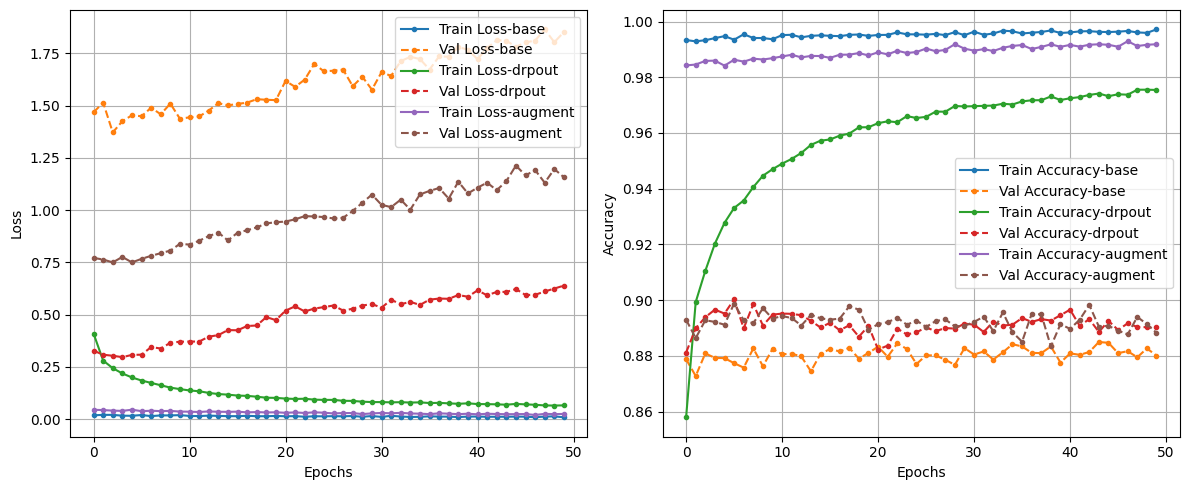

Train Accuracy base: 0.9971666932106018
Validation Accuracy base: 0.8801000118255615
Train Accuracy drpout: 0.975433349609375
Validation Accuracy drpout: 0.8902000188827515
Train Accuracy augment: 0.9918456673622131
Validation Accuracy augment: 0.8883000016212463


In [22]:
epochs = 50
batch_size = 64
steps_per_epoch = len(y_train) // batch_size
generator = datagen(x_train, y_train, batch_size)
print(x_train.shape)

history2 = fit_model_generator(model,generator)
plot_histories([history, history1, history2],["base", "drpout", "augment"])

### Questions

* What have you done in order to improve the performance?
* Have you tried configurations that did not work out?